In [1]:
import pandas as pd
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
import dgl

In [2]:
file_path = "NF-BoT-IoT.csv"
data = pd.read_csv(file_path)
data = data.drop_duplicates(subset=['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT'])
data = data.reset_index().drop(['index'], axis=1)
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.100.6,52670,192.168.100.1,53,17,5.212,71,126,1,1,0,4294966,0,Benign
1,192.168.100.6,49160,192.168.100.149,4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,Theft
2,192.168.100.46,3456,192.168.100.5,80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,Benign
3,192.168.100.3,80,192.168.100.55,8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,Benign
4,192.168.100.46,80,192.168.100.5,80,6,7.000,8374706,0,9086,0,0,4175916,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494963,192.168.100.150,36888,192.168.100.3,22,6,92.000,1478,3276,13,14,31,4292387,1,Theft
494964,192.168.100.150,36890,192.168.100.3,22,6,92.000,1478,3276,13,14,31,4292392,1,Theft
494965,192.168.100.150,36892,192.168.100.3,22,6,92.000,1530,3276,14,14,31,4292397,1,Theft
494966,192.168.100.150,36894,192.168.100.3,22,6,92.000,1478,3276,13,14,31,4292450,1,Theft


In [17]:
np.unique(data['Attack'], return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 11640,  43269,     21, 438458,   1580]))

In [6]:
value, num = np.unique(data['L7_PROTO'], return_counts=True)
print(np.unique(data['L7_PROTO'], return_counts=True))
print(len(num))

(array([  0.   ,   1.   ,   1.7  ,   2.   ,   2.7  ,   3.   ,   3.7  ,
         4.   ,   4.7  ,   5.   ,   5.126,   5.178,   5.212,   5.22 ,
         5.239,   5.24 ,   7.   ,   7.131,   8.   ,   9.169,  10.   ,
        11.   ,  13.   ,  14.   ,  17.   ,  18.   ,  19.   ,  20.   ,
        23.   ,  23.7  ,  28.   ,  29.   ,  29.7  ,  37.   ,  41.   ,
        42.   ,  44.   ,  50.   ,  51.   ,  51.7  ,  65.   ,  77.   ,
        78.39 ,  79.   ,  81.178,  85.   ,  88.   ,  89.   ,  91.   ,
        91.126,  91.178,  91.23 ,  91.239,  91.29 ,  91.51 ,  92.   ,
        96.   ,  97.   , 100.   , 111.   , 112.   , 114.   , 127.   ,
       131.   , 132.   , 139.   , 144.   , 146.   , 150.   , 153.   ,
       154.   , 158.   , 161.   , 164.   , 166.   , 167.   , 170.   ,
       172.   , 174.   , 175.   , 188.39 , 190.   , 196.   , 204.   ,
       213.   , 222.178, 226.   , 238.   , 244.   ]), array([411432,   2181,      5,    576,      7,    569,      3,    471,
            5,    562,   1281,    

In [8]:
def get_emb_feature_list():
    feature_list = ['PROTOCOL', 'L7_PROTO', 'TCP_FLAGS', 'Attack']
    return feature_list

def get_edge_feature(data, feature_list, attack, category):
    all_dict = {}
    for feature in feature_list:
        value = np.unique(np.array(data[feature]))
        print(value)
        length = len(value)
        value_dict = {}
        for i in range(length):
            value_dict[value[i]] = i
        
        data[feature] = data[feature].map(value_dict, na_action=None)
        all_dict[feature] = value_dict
        
    print(all_dict)
    
    feature = data.drop(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'Label', 'Attack'],
                     axis=1)
    attack_label = data[attack]
    category_label = data[category]

    return feature, attack_label, category_label, data

In [10]:
feature_list = get_emb_feature_list()
attack, category = "Label", "Attack"
edge_feature, attack_label, category_label, data = get_edge_feature(data, feature_list, attack, category)

[ 1  6 17]
[  0.      1.      1.7     2.      2.7     3.      3.7     4.      4.7
   5.      5.126   5.178   5.212   5.22    5.239   5.24    7.      7.131
   8.      9.169  10.     11.     13.     14.     17.     18.     19.
  20.     23.     23.7    28.     29.     29.7    37.     41.     42.
  44.     50.     51.     51.7    65.     77.     78.39   79.     81.178
  85.     88.     89.     91.     91.126  91.178  91.23   91.239  91.29
  91.51   92.     96.     97.    100.    111.    112.    114.    127.
 131.    132.    139.    144.    146.    150.    153.    154.    158.
 161.    164.    166.    167.    170.    172.    174.    175.    188.39
 190.    196.    204.    213.    222.178 226.    238.    244.   ]
[  0   2  17  18  19  20  21  22  24  25  26  27  28  29  30  31  43  61
  63 214]
['Benign' 'DDoS' 'DoS' 'Reconnaissance' 'Theft']
{'PROTOCOL': {1: 0, 6: 1, 17: 2}, 'L7_PROTO': {0.0: 0, 1.0: 1, 1.7: 2, 2.0: 3, 2.7: 4, 3.0: 5, 3.7: 6, 4.0: 7, 4.7: 8, 5.0: 9, 5.126: 10, 5.178: 11, 5

In [23]:
np.unique(category_label, return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 11640,  43269,     21, 438458,   1580]))

In [11]:
edge_feature

,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS
0,2,12,71,126,1,1,0,4294966
1,1,0,217753000,199100,4521,4049,8,4176249
2,2,0,8508021,8918372,9086,9086,0,4175916
3,1,16,8442138,9013406,9086,9086,0,4175916
4,1,16,8374706,0,9086,0,0,4175916
...,...,...,...,...,...,...,...,...
494963,1,55,1478,3276,13,14,15,4292387
494964,1,55,1478,3276,13,14,15,4292392
494965,1,55,1530,3276,14,14,15,4292397
494966,1,55,1478,3276,13,14,15,4292450


In [16]:
edges_data = pd.read_csv("all_pairs_balance.csv", header=None)
u, v = th.tensor(edges_data.iloc[:, 0]), th.tensor(edges_data.iloc[:, 1])
g = dgl.graph((u, v))
g.ndata['h'] = th.ones(g.num_nodes(), 8, dtype=th.float32)
# g.ndata['h_0'] = g.ndata['h']
g.edata['w'] = th.tensor(np.array(edge_feature), dtype=th.float32)
g.edata['label'] = th.tensor(category_label, dtype=th.float32)
# g.edata['train_mask'] = th.zeros(6312, dtype=th.bool).bernoulli(0.6)
g

Graph(num_nodes=77177, num_edges=494968,
      ndata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32)}
      edata_schemes={'w': Scheme(shape=(8,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32)})

In [18]:
import dgl.function as fn

class SAGE(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(SAGE, self).__init__()
        # A linear submodule for projecting the input and neighbor feature to the output.
        self.linear = nn.Linear(in_feat*2, out_feat) # W

    def forward(self, g, h):
        with g.local_scope():#在这个区域内对g的修改不会同步到原始的图上
            g.ndata['h'] = h
            g.update_all(    #对所有的节点和边采用下面的message函数和reduce函数
                message_func=fn.copy_u("h", "m"), #message函数：将节点特征'h'作为消息传递给邻居，命名为'm'
                reduce_func=fn.mean("m", "h_N"),  #reduce函数：将接收到的'm'信息取平均，保存至节点特征'h_N'
            )
            h_N = g.ndata["h_N"]
            h_total = th.cat([h, h_N], dim=1)
            return self.linear(h_total)


class Model(nn.Module):
    def __init__(self, in_features, out_features, mlp_in, mlp_out):
        super().__init__()
        self.sage = SAGE(in_features, out_features)
        self.dense2 = th.nn.Linear(mlp_in * 2, mlp_out)
    def forward(self, g, x):
        h = self.sage(g, x)
        h_1 = self.sage(g, h)
        h_2 = self.sage(g, h_1)
        g.ndata['new_h'] = h_2
        g.apply_edges(lambda edges: {'x': th.cat([edges.src['new_h'], edges.dst['new_h']], dim=1)})
        rs = self.dense2(g.edata['x'])

        
        return rs


In [19]:
node_features = g.ndata['h']
edge_label = th.tensor(g.edata['label'])
# train_mask = g.edata['train_mask']
model = Model(8, 8, 8, 5)
opt = th.optim.Adam(model.parameters())

category_label = th.tensor(category_label)
category_y =  th.tensor(F.one_hot(category_label), dtype=th.float)

loss_list = []
for epoch in range(200):
    pred = model(g, node_features)
    level = th.argmax(pred, 1)
    print(np.unique(level, return_counts=True))
    loss = F.mse_loss(pred, category_y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    print("epoch = ", epoch, loss.item())
    one_loss = [epoch, loss.item()]
    loss_list.append(one_loss)

/var/folders/sn/n9tkzgmj79j03qt8d0vm52p00000gn/T/ipykernel_14555/3593066469.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_label = th.tensor(g.edata['label'])
/var/folders/sn/n9tkzgmj79j03qt8d0vm52p00000gn/T/ipykernel_14555/3593066469.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  category_y =  th.tensor(F.one_hot(category_label), dtype=th.float)
/Users/fanyan/anaconda3/envs/So-DIEN/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use 

(array([2]), array([494968]))
epoch =  0 0.22666937112808228
(array([2]), array([494968]))
epoch =  1 0.22124306857585907
(array([2]), array([494968]))
epoch =  2 0.2158883959054947
(array([2]), array([494968]))
epoch =  3 0.21060466766357422
(array([2]), array([494968]))
epoch =  4 0.20539021492004395
(array([2]), array([494968]))
epoch =  5 0.20024526119232178
(array([2]), array([494968]))
epoch =  6 0.1951674371957779
(array([2]), array([494968]))
epoch =  7 0.19015377759933472
(array([2]), array([494968]))
epoch =  8 0.1852000653743744
(array([2]), array([494968]))
epoch =  9 0.18030329048633575
(array([2]), array([494968]))
epoch =  10 0.17545878887176514
(array([2]), array([494968]))
epoch =  11 0.17066627740859985
(array([2]), array([494968]))
epoch =  12 0.16592200100421906
(array([2, 3]), array([494963,      5]))
epoch =  13 0.1612224131822586
(array([2, 3]), array([494773,    195]))
epoch =  14 0.15656623244285583
(array([2, 3]), array([494751,    217]))
epoch =  15 0.1519493

epoch =  130 0.03737051412463188
(array([3]), array([494968]))
epoch =  131 0.03735007718205452
(array([3]), array([494968]))
epoch =  132 0.03732992708683014
(array([3]), array([494968]))
epoch =  133 0.03730952739715576
(array([3]), array([494968]))
epoch =  134 0.037289511412382126
(array([3]), array([494968]))
epoch =  135 0.03726967051625252
(array([3]), array([494968]))
epoch =  136 0.037248142063617706
(array([3]), array([494968]))
epoch =  137 0.03722953051328659
(array([3]), array([494968]))
epoch =  138 0.03720822185277939
(array([3]), array([494968]))
epoch =  139 0.037187643349170685
(array([3]), array([494968]))
epoch =  140 0.037169281393289566
(array([3]), array([494968]))
epoch =  141 0.03714945912361145
(array([3]), array([494968]))
epoch =  142 0.03712829202413559
(array([3]), array([494968]))
epoch =  143 0.0371103473007679
(array([3]), array([494968]))
epoch =  144 0.03709050640463829
(array([3]), array([494968]))
epoch =  145 0.037069641053676605
(array([3]), array

epoch =  260 0.03517865017056465
(array([3]), array([494968]))
epoch =  261 0.03516976907849312
(array([3]), array([494968]))
epoch =  262 0.0351591557264328
(array([3]), array([494968]))
epoch =  263 0.03515030816197395
(array([3]), array([494968]))
epoch =  264 0.03514068201184273
(array([3]), array([494968]))
epoch =  265 0.03513142094016075
(array([3]), array([494968]))
epoch =  266 0.035121750086545944
(array([3]), array([494968]))
epoch =  267 0.035112157464027405
(array([3]), array([494968]))
epoch =  268 0.035103753209114075
(array([3]), array([494968]))
epoch =  269 0.035093676298856735
(array([3]), array([494968]))
epoch =  270 0.0350838340818882
(array([3]), array([494968]))
epoch =  271 0.03507620096206665
(array([3]), array([494968]))
epoch =  272 0.0350668802857399
(array([3]), array([494968]))
epoch =  273 0.03505834937095642
(array([3]), array([494968]))
epoch =  274 0.03504953905940056
(array([3]), array([494968]))
epoch =  275 0.03504171594977379
(array([3]), array([4

(array([3]), array([494968]))
epoch =  391 0.03450034558773041
(array([3]), array([494968]))
epoch =  392 0.034497033804655075
(array([3]), array([494968]))
epoch =  393 0.03449367359280586
(array([3]), array([494968]))
epoch =  394 0.03449195995926857
(array([3]), array([494968]))
epoch =  395 0.03448978811502457
(array([3]), array([494968]))
epoch =  396 0.03448661044239998
(array([3]), array([494968]))
epoch =  397 0.03448481112718582
(array([3]), array([494968]))
epoch =  398 0.034482963383197784
(array([3]), array([494968]))
epoch =  399 0.03447840362787247
(array([3]), array([494968]))
epoch =  400 0.03447622433304787
(array([3]), array([494968]))
epoch =  401 0.034474439918994904
(array([3]), array([494968]))
epoch =  402 0.034471236169338226
(array([3]), array([494968]))
epoch =  403 0.034467797726392746
(array([3]), array([494968]))
epoch =  404 0.03446589782834053
(array([3]), array([494968]))
epoch =  405 0.03446333482861519
(array([3]), array([494968]))
epoch =  406 0.03446

epoch =  521 0.03423028066754341
(array([3]), array([494968]))
epoch =  522 0.034227654337882996
(array([3]), array([494968]))
epoch =  523 0.034227676689624786
(array([3]), array([494968]))
epoch =  524 0.034226253628730774
(array([3]), array([494968]))
epoch =  525 0.034225642681121826
(array([3]), array([494968]))
epoch =  526 0.034224290400743484
(array([3]), array([494968]))
epoch =  527 0.03422151133418083
(array([3]), array([494968]))
epoch =  528 0.03422008454799652
(array([3]), array([494968]))
epoch =  529 0.03421871364116669
(array([3]), array([494968]))
epoch =  530 0.034217312932014465
(array([3]), array([494968]))
epoch =  531 0.034214895218610764
(array([3]), array([494968]))
epoch =  532 0.03421275317668915
(array([3]), array([494968]))
epoch =  533 0.0342111811041832
(array([3]), array([494968]))
epoch =  534 0.03421024978160858
(array([3]), array([494968]))
epoch =  535 0.03420891985297203
(array([3]), array([494968]))
epoch =  536 0.0342065691947937
(array([3]), arra

(array([3]), array([494968]))
epoch =  652 0.03403753042221069
(array([3]), array([494968]))
epoch =  653 0.034036245197057724
(array([3]), array([494968]))
epoch =  654 0.034034695476293564
(array([3]), array([494968]))
epoch =  655 0.03403446078300476
(array([3]), array([494968]))
epoch =  656 0.03403346985578537
(array([3]), array([494968]))
epoch =  657 0.034032274037599564
(array([3]), array([494968]))
epoch =  658 0.0340297631919384
(array([3]), array([494968]))
epoch =  659 0.034028831869363785
(array([3]), array([494968]))
epoch =  660 0.034027304500341415
(array([3]), array([494968]))
epoch =  661 0.03402632102370262
(array([3]), array([494968]))
epoch =  662 0.034026045352220535
(array([3]), array([494968]))
epoch =  663 0.03402470797300339
(array([3]), array([494968]))
epoch =  664 0.03402266651391983
(array([3]), array([494968]))
epoch =  665 0.03402122110128403
(array([3]), array([494968]))
epoch =  666 0.03402017802000046
(array([3]), array([494968]))
epoch =  667 0.03401

epoch =  782 0.03389113023877144
(array([3]), array([494968]))
epoch =  783 0.03388918936252594
(array([3]), array([494968]))
epoch =  784 0.03388835862278938
(array([3]), array([494968]))
epoch =  785 0.03388797491788864
(array([3]), array([494968]))
epoch =  786 0.03388676419854164
(array([3]), array([494968]))
epoch =  787 0.0338861308991909
(array([3]), array([494968]))
epoch =  788 0.03388572111725807
(array([3]), array([494968]))
epoch =  789 0.03388512134552002
(array([3]), array([494968]))
epoch =  790 0.033883433789014816
(array([3]), array([494968]))
epoch =  791 0.03388229385018349
(array([3]), array([494968]))
epoch =  792 0.033880218863487244
(array([3]), array([494968]))
epoch =  793 0.03387937322258949
(array([3]), array([494968]))
epoch =  794 0.03387829661369324
(array([3]), array([494968]))
epoch =  795 0.03387730196118355
(array([3]), array([494968]))
epoch =  796 0.03387690335512161
(array([3]), array([494968]))
epoch =  797 0.03387659043073654
(array([3]), array([4

epoch =  912 0.03379015624523163
(array([3]), array([494968]))
epoch =  913 0.033790137618780136
(array([3]), array([494968]))
epoch =  914 0.03378979489207268
(array([3]), array([494968]))
epoch =  915 0.03378944844007492
(array([3]), array([494968]))
epoch =  916 0.03378790244460106
(array([3]), array([494968]))
epoch =  917 0.03378758952021599
(array([3]), array([494968]))
epoch =  918 0.03378523886203766
(array([3]), array([494968]))
epoch =  919 0.0337851382791996
(array([3]), array([494968]))
epoch =  920 0.033784862607717514
(array([3]), array([494968]))
epoch =  921 0.033784013241529465
(array([3]), array([494968]))
epoch =  922 0.03378363698720932
(array([3]), array([494968]))
epoch =  923 0.03378337249159813
(array([3]), array([494968]))
epoch =  924 0.03378283977508545
(array([3]), array([494968]))
epoch =  925 0.033781103789806366
(array([3]), array([494968]))
epoch =  926 0.033780649304389954
(array([3]), array([494968]))
epoch =  927 0.0337802991271019
(array([3]), array(

epoch =  1041 0.03371948376297951
(array([3]), array([494968]))
epoch =  1042 0.03371916338801384
(array([3]), array([494968]))
epoch =  1043 0.033718857914209366
(array([3]), array([494968]))
epoch =  1044 0.03371909260749817
(array([3]), array([494968]))
epoch =  1045 0.03371704742312431
(array([3]), array([494968]))
epoch =  1046 0.033716730773448944
(array([3]), array([494968]))
epoch =  1047 0.033716537058353424
(array([3]), array([494968]))
epoch =  1048 0.03371603041887283
(array([3]), array([494968]))
epoch =  1049 0.033715955913066864
(array([3]), array([494968]))
epoch =  1050 0.03371522203087807
(array([3]), array([494968]))
epoch =  1051 0.03371420130133629
(array([3]), array([494968]))
epoch =  1052 0.03371402993798256
(array([3]), array([494968]))
epoch =  1053 0.03371376916766167
(array([3]), array([494968]))
epoch =  1054 0.033713504672050476
(array([3]), array([494968]))
epoch =  1055 0.03371325880289078
(array([3]), array([494968]))
epoch =  1056 0.033712465316057205


(array([3]), array([494968]))
epoch =  1169 0.03366560488939285
(array([3]), array([494968]))
epoch =  1170 0.03366542235016823
(array([3]), array([494968]))
epoch =  1171 0.03366539627313614
(array([3]), array([494968]))
epoch =  1172 0.033664144575595856
(array([3]), array([494968]))
epoch =  1173 0.033663950860500336
(array([3]), array([494968]))
epoch =  1174 0.03366333246231079
(array([3]), array([494968]))
epoch =  1175 0.03366339951753616
(array([3]), array([494968]))
epoch =  1176 0.03366298973560333
(array([3]), array([494968]))
epoch =  1177 0.0336628332734108
(array([3]), array([494968]))
epoch =  1178 0.033662714064121246
(array([3]), array([494968]))
epoch =  1179 0.03366238996386528
(array([3]), array([494968]))
epoch =  1180 0.03366229310631752
(array([3]), array([494968]))
epoch =  1181 0.033662404865026474
(array([3]), array([494968]))
epoch =  1182 0.03366205468773842
(array([3]), array([494968]))
epoch =  1183 0.033661700785160065
(array([3]), array([494968]))
epoch 

(array([3]), array([494968]))
epoch =  1297 0.03362797573208809
(array([3]), array([494968]))
epoch =  1298 0.03362813591957092
(array([3]), array([494968]))
epoch =  1299 0.0336277112364769
(array([3]), array([494968]))
epoch =  1300 0.03362750634551048
(array([3]), array([494968]))
epoch =  1301 0.033627163618803024
(array([3]), array([494968]))
epoch =  1302 0.03362700343132019
(array([3]), array([494968]))
epoch =  1303 0.033626988530159
(array([3]), array([494968]))
epoch =  1304 0.03362646698951721
(array([3]), array([494968]))
epoch =  1305 0.03362531587481499
(array([3]), array([494968]))
epoch =  1306 0.03362530469894409
(array([3]), array([494968]))
epoch =  1307 0.033625029027462006
(array([3]), array([494968]))
epoch =  1308 0.0336248017847538
(array([3]), array([494968]))
epoch =  1309 0.03362464904785156
(array([3]), array([494968]))
epoch =  1310 0.03362417221069336
(array([3]), array([494968]))
epoch =  1311 0.03362386301159859
(array([3]), array([494968]))
epoch =  131

epoch =  1425 0.033606067299842834
(array([3]), array([494968]))
epoch =  1426 0.03360632061958313
(array([3]), array([494968]))
epoch =  1427 0.033605970442295074
(array([3]), array([494968]))
epoch =  1428 0.03360622376203537
(array([3]), array([494968]))
epoch =  1429 0.03360576927661896
(array([3]), array([494968]))
epoch =  1430 0.03360555320978165
(array([3]), array([494968]))
epoch =  1431 0.0336051844060421
(array([3]), array([494968]))
epoch =  1432 0.03360523656010628
(array([3]), array([494968]))
epoch =  1433 0.03360535949468613
(array([3]), array([494968]))
epoch =  1434 0.03360430523753166
(array([3]), array([494968]))
epoch =  1435 0.033603597432374954
(array([3]), array([494968]))
epoch =  1436 0.03360408544540405
(array([3]), array([494968]))
epoch =  1437 0.03360384330153465
(array([3]), array([494968]))
epoch =  1438 0.033603668212890625
(array([3]), array([494968]))
epoch =  1439 0.03360310569405556
(array([3]), array([494968]))
epoch =  1440 0.03360307961702347
(ar

epoch =  1553 0.03359149023890495
(array([3]), array([494968]))
epoch =  1554 0.03359280526638031
(array([3]), array([494968]))
epoch =  1555 0.03359257057309151
(array([3]), array([494968]))
epoch =  1556 0.03359244391322136
(array([3]), array([494968]))
epoch =  1557 0.033592600375413895
(array([3]), array([494968]))
epoch =  1558 0.033592965453863144
(array([3]), array([494968]))
epoch =  1559 0.03359226509928703
(array([3]), array([494968]))
epoch =  1560 0.03359236568212509
(array([3]), array([494968]))
epoch =  1561 0.03359200060367584
(array([3]), array([494968]))
epoch =  1562 0.033591628074645996
(array([3]), array([494968]))
epoch =  1563 0.03359193354845047
(array([3]), array([494968]))
epoch =  1564 0.033591993153095245
(array([3]), array([494968]))
epoch =  1565 0.033591993153095245
(array([3]), array([494968]))
epoch =  1566 0.033591799437999725
(array([3]), array([494968]))
epoch =  1567 0.033590901643037796
(array([3]), array([494968]))
epoch =  1568 0.03359081968665123

(array([3]), array([494968]))
epoch =  1681 0.033586274832487106
(array([3]), array([494968]))
epoch =  1682 0.033586058765649796
(array([3]), array([494968]))
epoch =  1683 0.03358587995171547
(array([3]), array([494968]))
epoch =  1684 0.03358570113778114
(array([3]), array([494968]))
epoch =  1685 0.03358690068125725
(array([3]), array([494968]))
epoch =  1686 0.03358680382370949
(array([3]), array([494968]))
epoch =  1687 0.03358674794435501
(array([3]), array([494968]))
epoch =  1688 0.033587075769901276
(array([3]), array([494968]))
epoch =  1689 0.03358706459403038
(array([3]), array([494968]))
epoch =  1690 0.03358693793416023
(array([3]), array([494968]))
epoch =  1691 0.033586595207452774
(array([3]), array([494968]))
epoch =  1692 0.0335853174328804
(array([3]), array([494968]))
epoch =  1693 0.033585429191589355
(array([3]), array([494968]))
epoch =  1694 0.03358527272939682
(array([3]), array([494968]))
epoch =  1695 0.0335855595767498
(array([3]), array([494968]))
epoch =

epoch =  1808 0.03358488529920578
(array([3]), array([494968]))
epoch =  1809 0.03358419984579086
(array([3]), array([494968]))
epoch =  1810 0.033584099262952805
(array([3]), array([494968]))
epoch =  1811 0.03358377516269684
(array([3]), array([494968]))
epoch =  1812 0.03358371555805206
(array([3]), array([494968]))
epoch =  1813 0.03358401358127594
(array([3]), array([494968]))
epoch =  1814 0.03358376398682594
(array([3]), array([494968]))
epoch =  1815 0.033583421260118484
(array([3]), array([494968]))
epoch =  1816 0.033585283905267715
(array([3]), array([494968]))
epoch =  1817 0.03358500450849533
(array([3]), array([494968]))
epoch =  1818 0.033584900200366974
(array([3]), array([494968]))
epoch =  1819 0.03358463943004608
(array([3]), array([494968]))
epoch =  1820 0.03358501195907593
(array([3]), array([494968]))
epoch =  1821 0.03358493000268936
(array([3]), array([494968]))
epoch =  1822 0.03358452022075653
(array([3]), array([494968]))
epoch =  1823 0.033584583550691605
(

epoch =  1936 0.0335816815495491
(array([3]), array([494968]))
epoch =  1937 0.03358190506696701
(array([3]), array([494968]))
epoch =  1938 0.03358179330825806
(array([3]), array([494968]))
epoch =  1939 0.03358194977045059
(array([3]), array([494968]))
epoch =  1940 0.03358234092593193
(array([3]), array([494968]))
epoch =  1941 0.03358198329806328
(array([3]), array([494968]))
epoch =  1942 0.03358188644051552
(array([3]), array([494968]))
epoch =  1943 0.03358142822980881
(array([3]), array([494968]))
epoch =  1944 0.033582914620637894
(array([3]), array([494968]))
epoch =  1945 0.0335826575756073
(array([3]), array([494968]))
epoch =  1946 0.03358268737792969
(array([3]), array([494968]))
epoch =  1947 0.03358392417430878
(array([3]), array([494968]))
epoch =  1948 0.033583883196115494
(array([3]), array([494968]))
epoch =  1949 0.03358256071805954
(array([3]), array([494968]))
epoch =  1950 0.033582840114831924
(array([3]), array([494968]))
epoch =  1951 0.033582672476768494
(arr

In [20]:
loss_list = pd.DataFrame(loss_list)
x = np.array(loss_list.iloc[:, 0])
y = np.array(loss_list.iloc[:, 1])
x

array([   0,    1,    2, ..., 1997, 1998, 1999])

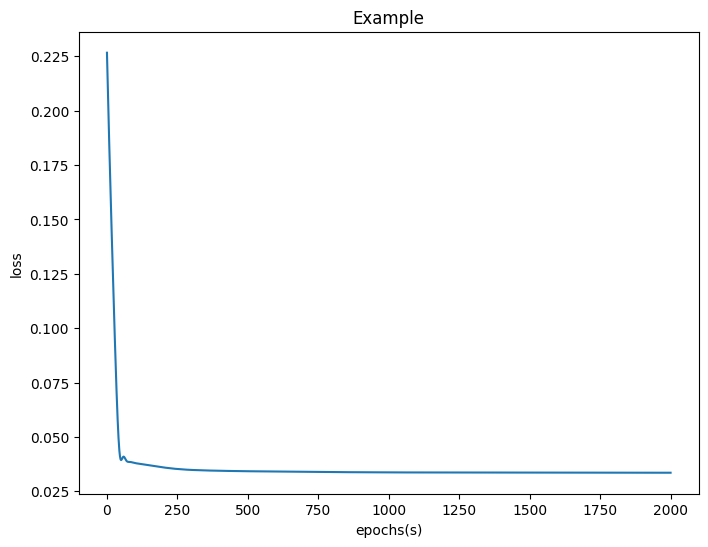

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))  # 定义图的大小
plt.xlabel("epochs(s)")     # X轴标签
plt.ylabel("loss")        # Y轴坐标标签
plt.title("Example")      #  曲线图的标题

plt.plot(x,y)            # 绘制曲线图
#在ipython的交互环境中需要这句话才能显示出来
plt.show()



In [25]:
th.save(model.state_dict(), 'model_weights.pth')

In [26]:
level = th.argmax(pred, 1)
level

tensor([1, 1, 1,  ..., 3, 3, 3])